Solve this exercise by using the demo notebook: Getting_Started_with_a_Movie_Recommendation_System.ipynb

Full path to the dataset: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?select=Books_rating.csv

In [ ]:
# Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download the data

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
data_path = kagglehub.dataset_download('mohamedbakhet/amazon-books-reviews')

print('Data source import complete.')

Data source import complete.


# Import the data

In [ ]:
#Load the dataframes


Describe the content of both dataframes

In [1]:
# Print first five rows of df_ratings


In [2]:
# Print first five rows of df_bookinfo


# Process the data

In [3]:
# We need the vote_count and vote_average to calculate the metric below. We will calculate these with df_ratings
# In df_ratings, calculate the vote average and vote count per book based on review/score column


In [4]:
# Merge df_bookinfo with vote_count and vote_average


In [5]:
# Select the first 20000 books, otherwise it will be difficult to do the calculations below with your RAM


# **Demographic Filtering** -
   Before getting started with this  -
* we need a metric to score or rate a book
* Calculate the score for every book
* Sort the scores and recommend the best rated book to the users.

We can use the average ratings of the book as the score but using this won't be fair enough since a book with 4.5 average rating and only 3 votes cannot be considered better than the book with 3.9 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

Now apply this on the books dataset instead of on movies.

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as

In [6]:
# Calculate C


So, the mean rating for all the books is approx 4.3 on a scale of 5.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the book in the list.

In [7]:
# calculate m


Now, we can filter out the books that qualify for the chart

In [8]:
# filter out the books that qualify for the chart


We see that there are 2025 books which qualify to be in this list. Now, we need to calculate our metric for each qualified book. To do this, we will define a function, **weighted_rating()** and define a new feature **score**, of which we'll calculate the value by applying this function to our DataFrame of qualified books:

In [9]:
# Construct a weighted_rating function that calculates the metric for each qualified book


In [10]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`


Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 books.

In [11]:
#Sort books based on score calculated above and print the top 10 books


Hurray! We have made our first(though very basic) recommender.
Under the **Trending Now** tab of these systems we find books that are very popular and they can just be obtained by sorting the dataset by the popularity column.

In [12]:
# Print the five most popular books based on the review/time column in df_ratings. Take all reviews into account of the last month in the dataset.


In [14]:
# Make a bar plot of the 5 most popular books


Now something to keep in mind is that these demographic recommender provide a general chart of recommended books to all the users. They are not sensitive to the interests and tastes of a particular user.
This is when we move on to a more refined system-  Content Based Filtering.

# **Content Based Filtering**
In this recommender system the content of the book is used to find its similarity with other books. Then the books that are most likely to be similar are recommended.

## **Plot description based Recommender**

We will compute pairwise similarity scores for all books based on their plot descriptions and recommend books based on that similarity score. The plot description is given in the **overview** feature of our dataset.
Let's take a look at the data. ..

In [15]:
# Display the first five rows of the 'description' column in bookinfo


For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a book, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it?

In [16]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'


We see that over 68000 different words were used to describe the more than 20000 selected books in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two books. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
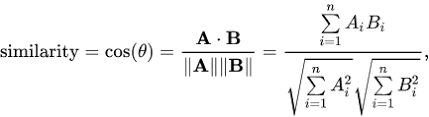

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [17]:
# Compute the cosine similarity matrix


We are going to define a function that takes in a book title as an input and outputs a list of the 10 most similar books. Firstly, for this, we need a reverse mapping of book titles and DataFrame indices. In other words, we need a mechanism to identify the index of a book in our metadata DataFrame, given its title.

In [18]:
#Construct a reverse map of indices and book titles


We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the book given its title.
* Get the list of cosine similarity scores for that particular book with all books. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the book most similar to a particular book is the book itself).
* Return the titles corresponding to the indices of the top elements.

In [19]:
# Function that takes in book title as input and outputs most similar books


In [ ]:
get_recommendations('The Battleship Bismarck', cosine_sim)

,Title
18402,The last nine days of the Bismarck
6849,Admirals in Collision
17238,Band of Brothers: Boy Seamen in the Royal Navy...
6133,Sharpe's Trafalgar (Richard Sharpe's Adventure...
9557,Cunard: 150 Glorious Years
8110,The Letter of Marque (Aubrey-Maturin)
14325,Distant Gunfire
476,United States Navy Aircraft Since 1911
10193,"Germany's high sea fleet in the world war,"
14764,Captain Kilburnie


In [ ]:
get_recommendations('Wonderful Worship in Smaller Churches', cosine_sim)

,Title
17660,Classic Children's Prayers (Little Prayer Series)
3918,"The Ultimate Priority: John Macarthur, Jr. on ..."
13467,For the Audience of One: Worshiping the One an...
13872,"Psalms In Worship, The (Lillenas Drama)"
3230,The Worship Leader's Handbook: Practical Answe...
7926,"When We Gather, Revised Edition: A Book of Pra..."
10186,The Cokesbury Worship Hymnal
9910,Whatever Happened to Worship: A Call To True W...
16142,Catholics
14377,As It Is in Heaven


## **Authors, publisher, published date and Genres Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the authors, the publisher, the published date and related genres.

We need to convert the data into safe and useable features first.
* Authors and categories are a list of strings -> convert stringified list to a list
* Publisher is a string -> ok
* published date is a date -> this has to be converted to a float and normalised

In [20]:
# Convert stringified list to a list


In [21]:
# Convert all values in publishedDate to a string of the year. Some entries are in 'year' format, some in 'year-month-day' format
# If values are Nan, return Nan


In [22]:
# Print the new features of the first 5 books


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [23]:
# Function to convert all strings to lower case and strip names of spaces


In [24]:
# Apply clean_data function to your features.


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer.

In [25]:
# Create a metadata soup using the function seen in the demo


The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of for example an author if he or she has written more books. It doesn't make much intuitive sense.

In [26]:
# Create the count matrix


In [27]:
# Compute the Cosine Similarity matrix based on the count_matrix


In [28]:
# Reset index of our main DataFrame and construct reverse mapping as before


We can now reuse our **get_recommendations()** function by passing in the new **cosine_sim2** matrix as your second argument.

In [ ]:
get_recommendations('The Battleship Bismarck', cosine_sim2)

,Title
14,A husband for Kutani
656,Crusade of the Left: The Lincoln battalion in ...
2075,Snorri Sturluson: Ein biografi (Norwegian Edit...
3731,Spirit Song: The Introduction of No-Eyes
4217,Queen of France;: A biography of Marie Antoinette
5935,"Growth in holiness; or, The progress of the sp..."
7750,"The complete memoirs of George Sherston,"
9062,England Under The Tudors
12109,A German Ace Tells Why: From Kaiserdom to Hitl...
12165,"A History of Russia, Central Asia and Mongolia..."


In [ ]:
get_recommendations('Wonderful Worship in Smaller Churches', cosine_sim2)

,Title
1546,A Philadelphia Catholic to King James's Court:...
1730,Searching for an Adequate God: A Dialogue betw...
2395,My Soul Thirsts: An Invitation to Intimacy Wit...
5000,Word pictures in the New Testament
6499,And I Will Dwell in Their Midst: Orthodox Jews...
7059,Raw Faith: Nurturing the Believer in All of Us
9706,Journey to Self-Realization - Collected Talks ...
10544,Reconstructing Catholicism
13181,The Koran
13273,Directions for Communication Discoveries with ...


On first glance, the recommendations look trustworthy. But it is difficult to see whether these recommendations are better than the ones with the first cosine_sim. We need the test methods described in the theory to check this.

# **Collaborative Filtering**

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers.
It is basically of two types:-

*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.
This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.
![](https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png)

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is ***scalability***. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, ***sparsity*** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.



### **Single Value Decomposition**
One way to handle the scalability and sparsity issue created by CF is to leverage a **latent factor model** to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). **The lower the RMSE, the better the performance**.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

![](https://cdn-images-1.medium.com/max/800/1*GUw90kG2ltTd2k_iv3Vo0Q.png)

Now enough said , let's see how to implement this.
Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the [**Surprise** ](https://surprise.readthedocs.io/en/stable/index.html) library to implement SVD.

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357274 sha256=8cd1d2ee45dcc5c02fc458ac67bc21c5643ddca5c79fa653ebff73230f39ff89
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate # Import the cross_validate function

reader = Reader()
df_ratings.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,1999-10-23,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,2004-09-21,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,2004-03-09,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,2004-07-25,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,2005-02-10,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [29]:
# Apply SVD as seen in the demo, explain the result
# load relevant data


In [31]:
# Construct SVD


In [32]:
# Fit SVD


In [33]:
# Pick user with ID 'A30TK6U7DNS82R' and check it's ratings


In [34]:
# Check the estimated rating of the user with ID 'A30TK6U7DNS82R' on book '0802841899'


For book with ID 0802841899, we get an estimated prediction of **4.2**. One startling feature of this recommender system is that it doesn't care what the book is (or what it contains). It works purely on the basis of an assigned book ID and tries to predict ratings based on how the other users have predicted the book